In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
def score_model(model, x, y, n_splits=10, n_repeats=10):
    scoring = 'neg_root_mean_squared_error'
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    scores = cross_val_score(model, x, y, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

In [3]:
def plot_predictions(linreg_model, df, index, x, y):
    d = df['Data/Hora'].values
    test_series = pd.DataFrame({'ccs28':y}, index=pd.to_datetime(d))
    pred_series = linreg_model.predict(scaler.transform(x))
    pred_series = pd.DataFrame({'ccs28-pred' : pred_series}, index=pd.to_datetime(d))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color='r') # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(["train and test series", "end of train series", 'predicted'], loc="upper left")
    # ax.set_xlabel('Period', labelpad=20, fontsize=15)
    ax.set_ylabel('Compressive Strength - MPa', labelpad=20, fontsize=15)
    plt.show()

In [4]:
def plot_scores_box_plot(scores, repeats, n_splits):
    plt.figure(figsize=(15,8))
    plt.boxplot(scores.reshape((repeats, n_splits)), labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
    plt.ylabel('RMSE', labelpad=20, fontsize=15)
    plt.xlabel('Repeats', labelpad=20, fontsize=15)
    plt.show()

## Dataset

The datasets used here were prepared without resampling. The methods used to fill the missings and create new features can be checked in the feature engineering directory in the notebook directory of this project.

In [5]:
name = "dados-historicos-partner_i-cement-CPIIF40.csv"
df_r3d_and_r7d = pd.read_csv("../../../../data/interim/" + "r3d_and_r7d-no-resampling-with-fillna-" + name)
df_r3d_only = pd.read_csv("../../../../data/interim/" + "r3d_only-no-resampling-with-fillna-" + name)
df_no_r3d_r7d = pd.read_csv("../../../../data/interim/" + "no-r3d-r7d-no-resampling-with-fillna-" + name)

## Feature Selection

### In this notebook we remove variables that could potentially cause data leakage. Thus we are performing testings removing the following variables:

#### IP - Initial setting time
#### FP - Final setting time


#### BL - Blaine specific surface (This is both removed and use)

### Since we are using linear regression here we will also make experiments removing variables with pearson correlation coeficient above 0.75.

| Variable     |     -     | Pearson  |
|--------------|-----------|----------|
| CALCÁRIO     | CALCITA   | 0.889139 |
| GESSO        | GIPSITA   | 0.873226 |
| FERRITA      | FE2O3     | 0.869626 |
| DESIDRATAÇÃO | BASSANITA | 0.868792 |
| DESIDRATAÇÃO | GIPSITA   | 0.841888 |
| #325         | #400      | 0.807708 |
| R3D          | R7D       | 0.751261 |
| AE7D         | AE28D     | 0.750663 |

# Linear Regression

In [6]:
seed = 47
scaler = StandardScaler()
repeats = 10
n_splits = 10
linreg_model = LinearRegression()
pipeline = Pipeline([('transformer', scaler), ('estimator', linreg_model)])

# 1.  Repeated KFold Cross validation

## 1.1 Dataset: no-r3d-r7d-no-resampling-with-fillna

<h3>Experiment 1</h3>
<h4> Repeated KFold Cross Validation</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [7]:
y = df_no_r3d_r7d['R28D'].values
x = df_no_r3d_r7d.drop(['Data/Hora', 'R28D', 'IP', 'FP'], axis=1).values

In [8]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=seed)
scores = cross_val_score(
    pipeline, x, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)
scores = np.abs(scores)
print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

RMSE: 1.923 (0.237)


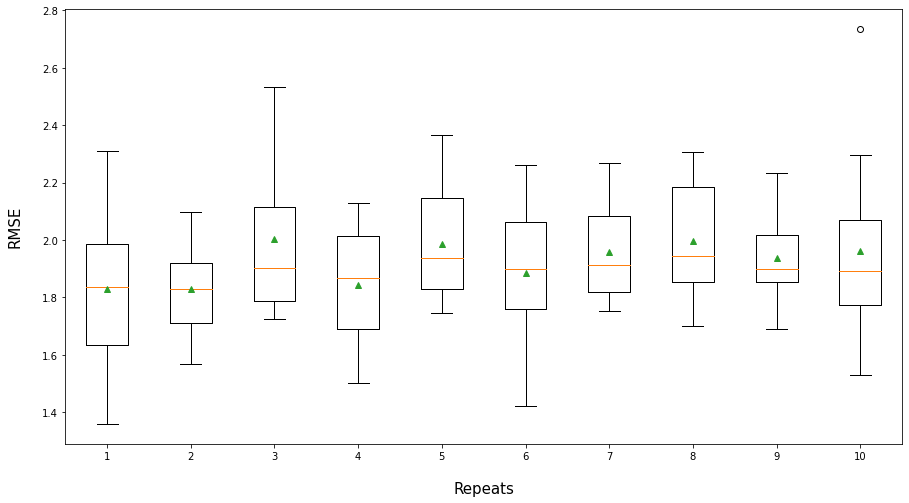

In [9]:
plot_scores_box_plot(scores, repeats, n_splits)

<h3>Experiment 2</h3>
<h4> Repeated KFold Cross Validation</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

<b>Feature Selection:</b> The BL variable is not used.

In [10]:
y = df_no_r3d_r7d['R28D'].values
x = df_no_r3d_r7d.drop(['Data/Hora', 'R28D', 'IP', 'FP', 'BL'], axis=1).values

In [11]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=seed)
scores = cross_val_score(
    pipeline, x, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)
scores = np.abs(scores)
print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

RMSE: 1.920 (0.235)


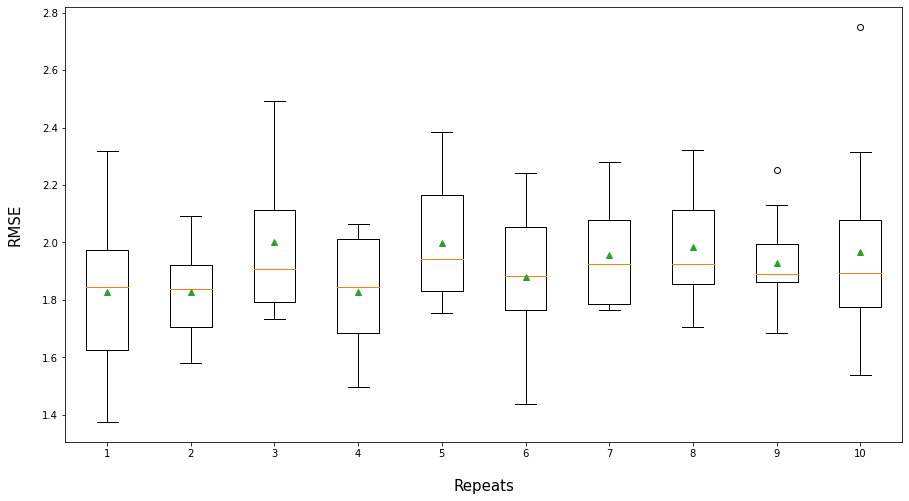

In [12]:
plot_scores_box_plot(scores, repeats, n_splits)

<h3>Experiment 3</h3>
<h4> Repeated KFold Cross Validation</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D are not considered

<b>Feature Selection:</b> 

1. The BL variable is not used.
2. High correlated variables are removed

In [13]:
to_drop = [
    "Data/Hora",
    "R28D",
    "IP",
    "FP",
    "BL",
    "CALCITA",
    "DESIDRATAÇÃO",
    "GIPSITA",
    "TIO2",
    "AL2O3",
    "PF",
    "FERRITA", 
    "#400"
]
y = df_no_r3d_r7d["R28D"].values
x = df_no_r3d_r7d.drop(to_drop, axis=1).values

In [14]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=seed)
scores = cross_val_score(
    pipeline, x, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)
scores = np.abs(scores)
print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

RMSE: 1.908 (0.219)


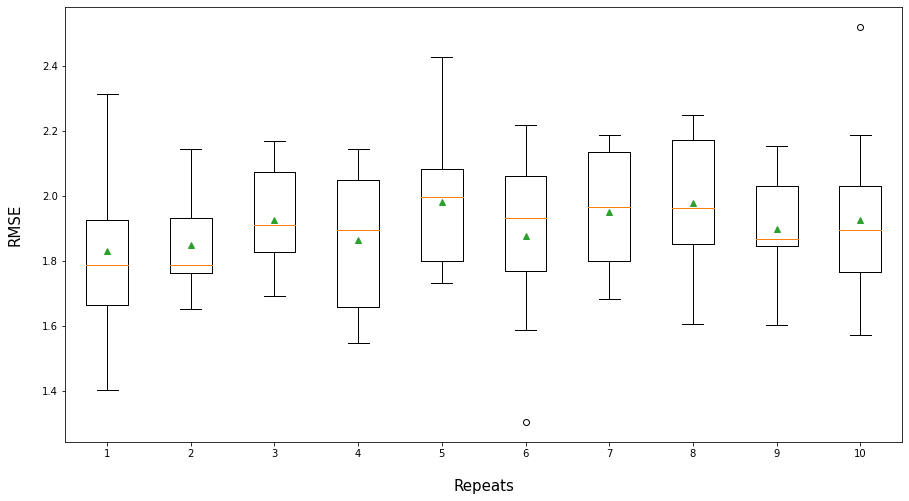

In [15]:
plot_scores_box_plot(scores, repeats, n_splits)

## 1.2 Dataset: r3d_only-no-resampling-with-fillna

<h3>Experiment 4</h3>
<h4> Repeated KFold Cross Validation - df_r3d-only</h4>

<b>Dataset: df_r3d-only:</b> In this dataset the R7D variable is not considered.

In [16]:
y = df_r3d_only['R28D'].values
x = df_r3d_only.drop(['Data/Hora', 'R28D', 'IP', 'FP'], axis=1).values

In [17]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=seed)
scores = cross_val_score(
    pipeline, x, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)
scores = np.abs(scores)
print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

RMSE: 1.582 (0.285)


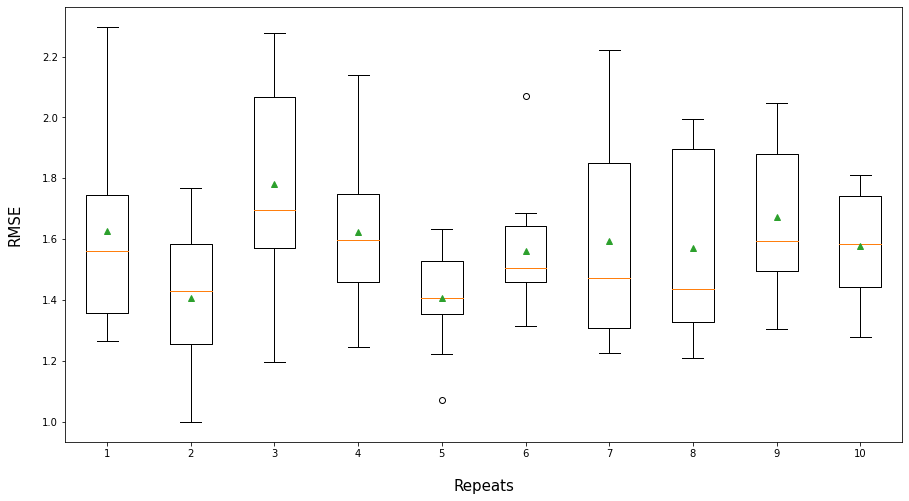

In [18]:
plot_scores_box_plot(scores, repeats, n_splits)

<h3>Experiment 5</h3>
<h4> Repeated KFold Cross Validation - df_r3d-only</h4>

<b>Dataset: df_r3d-only:</b> In this dataset the R7D variable is not considered.

<b>Feature Selection:</b> The BL variable is not used.

In [19]:
y = df_r3d_only['R28D'].values
x = df_r3d_only.drop(['Data/Hora', 'R28D', 'IP', 'FP', 'BL'], axis=1).values

In [20]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=seed)
scores = cross_val_score(
    pipeline, x, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)
scores = np.abs(scores)
print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

RMSE: 1.576 (0.284)


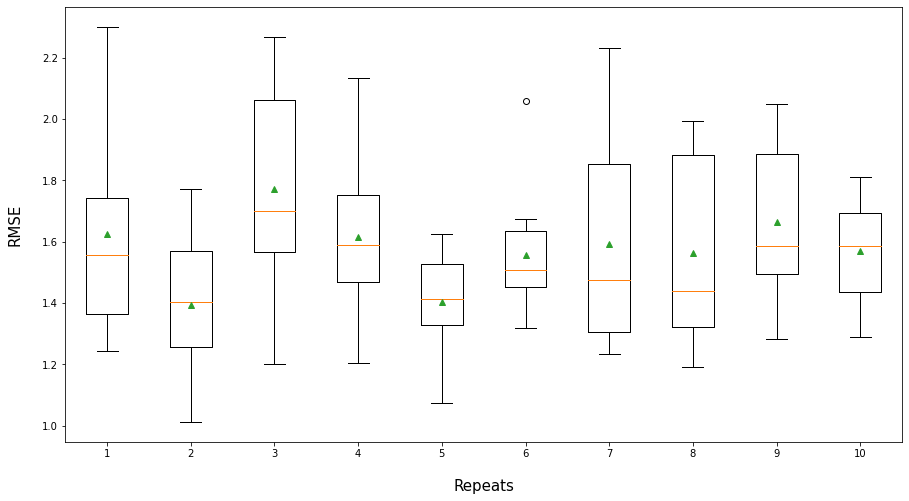

In [21]:
plot_scores_box_plot(scores, repeats, n_splits)

<h3>Experiment 6</h3>
<h4> Repeated KFold Cross Validation</h4>

<b>Dataset: df_r3d_only:</b> In this dataset the R7D is not considered

<b>Feature Selection:</b> 

1. The BL variable is not used.
2. High correlated variables are removed

In [36]:
to_drop = [
    "Data/Hora",
    "R28D",
    "IP",
    "FP",
    "BL",
    "CALCITA",
    "DESIDRATAÇÃO",
    "GIPSITA",
    "TIO2",
    "AL2O3",
    "PF",
    "FERRITA", 
    "#400"
]
y = df_r3d_only["R28D"].values
x = df_r3d_only.drop(to_drop, axis=1).values

In [37]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=seed)
scores = cross_val_score(
    pipeline, x, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)
scores = np.abs(scores)
print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

RMSE: 1.545 (0.264)


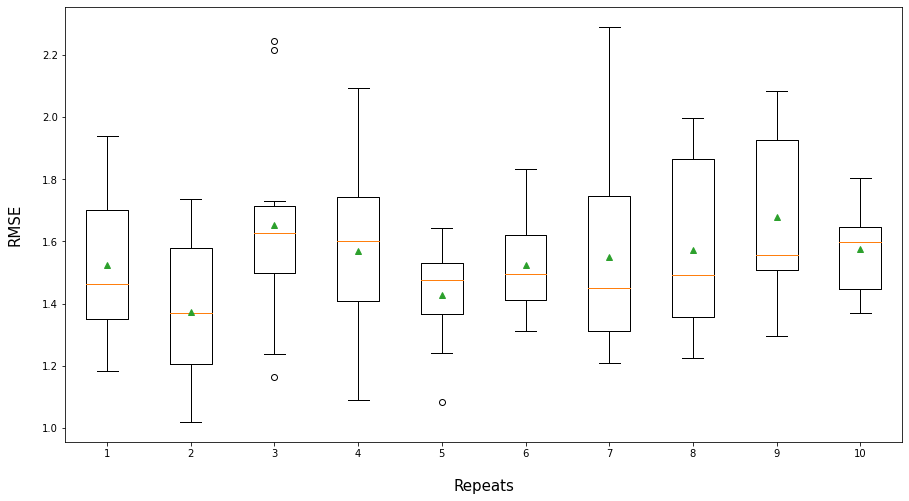

In [38]:
plot_scores_box_plot(scores, repeats, n_splits)

## 1.3 Dataset: r3d_and_r7d-no-resampling-with-fillna

<h3>Experiment 7</h3>
<h4> Repeated KFold Cross Validation - df_r3d-and-rd7</h4>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [25]:
y = df_r3d_and_r7d['R28D'].values
x = df_r3d_and_r7d.drop(['Data/Hora', 'R28D', 'IP', 'FP'], axis=1).values

In [26]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=seed)
scores = cross_val_score(pipeline, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.abs(scores)
print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

RMSE: 1.396 (0.192)


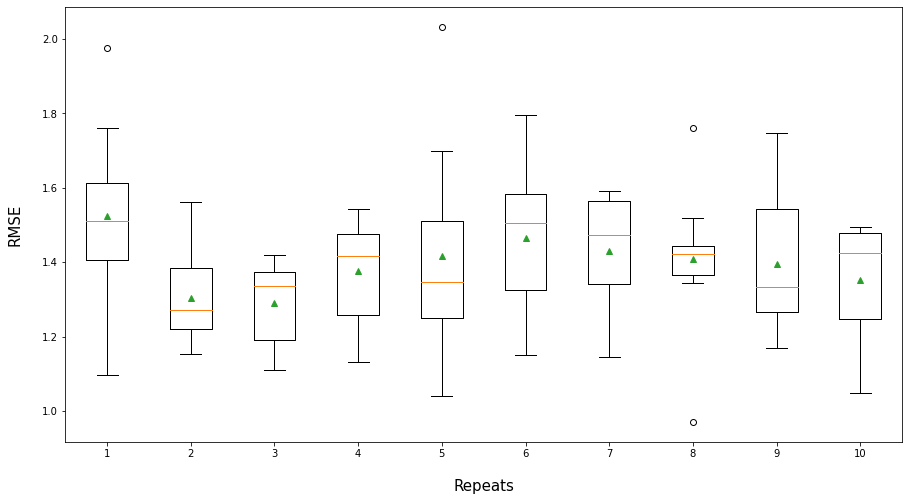

In [27]:
plot_scores_box_plot(scores, repeats, n_splits)

<h3>Experiment 8</h3>
<h4> Repeated KFold Cross Validation - df_r3d-and-rd7</h4>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

<b>Feature Selection:</b> The BL variable is not used.

In [28]:
y = df_r3d_and_r7d['R28D'].values
x = df_r3d_and_r7d.drop(['Data/Hora', 'R28D', 'IP', 'FP', 'BL'], axis=1).values

In [29]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=seed)
scores = cross_val_score(pipeline, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.abs(scores)
print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

RMSE: 1.389 (0.193)


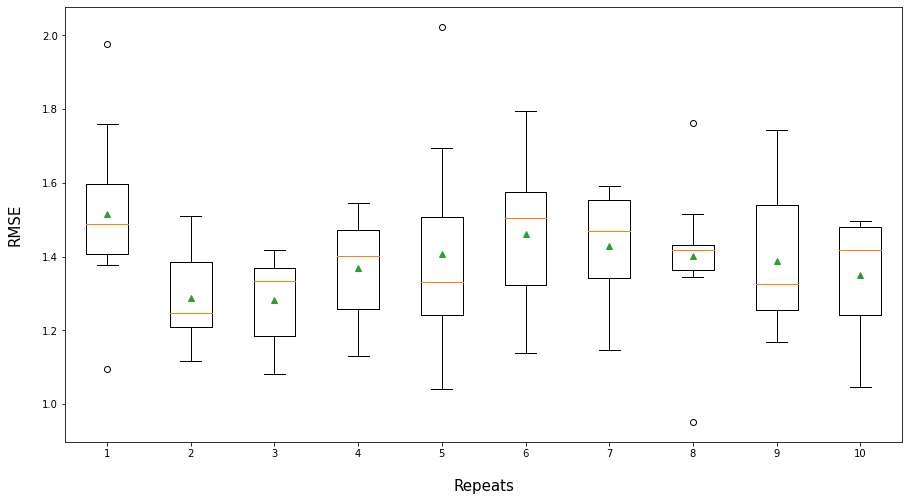

In [30]:
plot_scores_box_plot(scores, repeats, n_splits)

<h3>Experiment 9</h3>
<h4> Repeated KFold Cross Validation</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D are used

<b>Feature Selection:</b> 

1. The BL variable is not used.
2. High correlated variables are removed

In [31]:
to_drop = [
    "Data/Hora",
    "R28D",
    "IP",
    "FP",
    "BL",
    "CALCITA",
    "DESIDRATAÇÃO",
    "GIPSITA",
    "TIO2",
    "AL2O3",
    "PF",
    "FERRITA", 
    "#400"
]
y = df_r3d_and_r7d["R28D"].values
x = df_r3d_and_r7d.drop(to_drop, axis=1).values

In [32]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=seed)
scores = cross_val_score(
    pipeline, x, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
)
scores = np.abs(scores)
print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

RMSE: 1.347 (0.177)


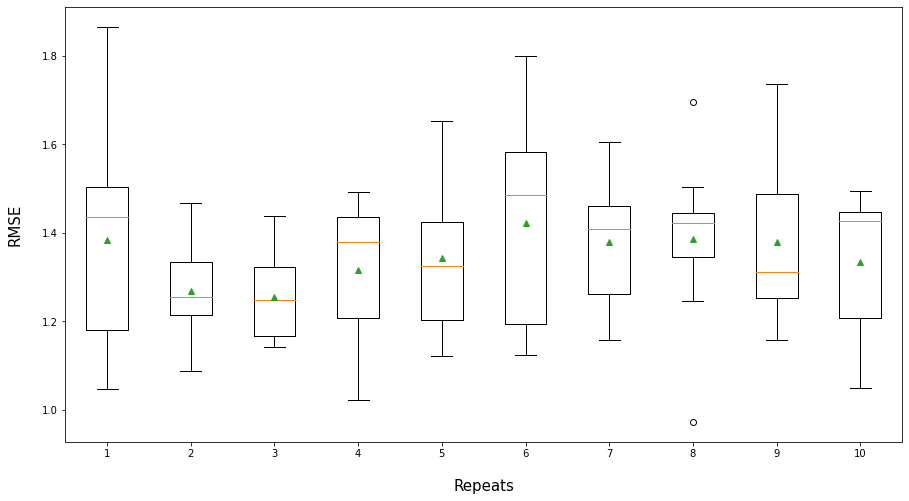

In [33]:
plot_scores_box_plot(scores, repeats, n_splits)